<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/multiframeEstimation/blob/main/color_autoencoder_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Fri Mar 26 15:00:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# ! unzip -q /content/drive/MyDrive/blender_512.zip

### diagram
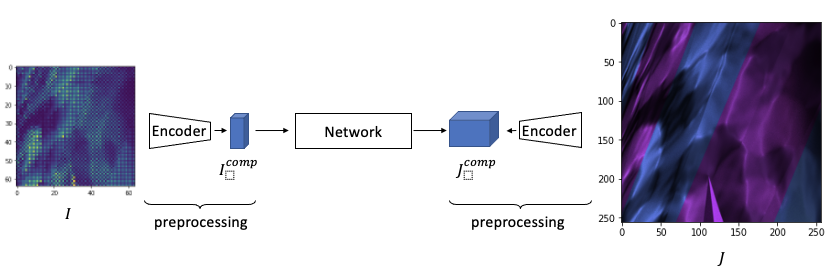

### training data
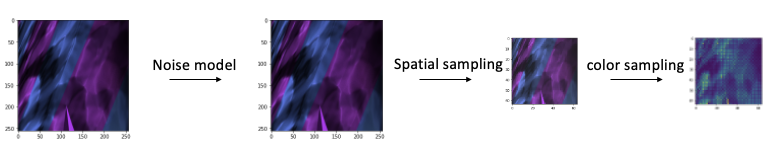

## Autoencoders

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.numpy()
    npimg = (np.clip(npimg * 1.4 + 1.3, 0, 8)/8)**0.5
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def load_exr(path):
        img = cv2.imread(path,cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
random.seed(38)
np.random.seed(38)
torch.manual_seed(38)

In [3]:
import os
import cv2

class SynDataset(torch.utils.data.Dataset):
    def __init__(self, root, train = True, transform = None):
        self.root = root
        self.train = train
        self.transform = transform

    def __len__(self):
        if self.train:
            return 1600
        else:
            return 400
    
    def __getitem__(self, index):
        if self.train:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        else:
            X = load_exr(os.path.join(self.root, "scene{:04d}".format(index//100 + 16), 
                                  "Image", "Image{:04d}.exr".format(index % 100 + 1)))
        X = self.randomCrop(X)
        X = torch.from_numpy(X.transpose(2, 0, 1)).float()
        return (X - 1.3)/1.4

    def randomCrop(self, img, size = 256):
        H, W, C = img.shape
        x = np.random.randint(0, H - size + 1)
        y = np.random.randint(0, W - size + 1)
        return img[x:x+size, y:y+size]

In [4]:
trainset = SynDataset(root='/content', train=True, transform=None) ## set root to '.' doesnt work
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)
testset = SynDataset(root='/content', train=False, transform=None)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

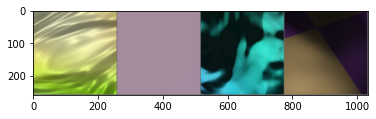

In [5]:
dataiter = iter(trainloader)
images = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))

### color autoencoder

In [6]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def deconv4x4(in_planes, out_planes, stride=2):
    return nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1, bias=True)

In [7]:
class colorAutoEncoder(nn.Module):
    def __init__(self, in_planes, feature_planes):
        super(colorAutoEncoder, self).__init__()
        ''' encoder'''
        self.encoder = nn.Sequential(
            conv3x3(in_planes, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, 64, 2),
            nn.ReLU(inplace = True),
            conv3x3(64, feature_planes, 2),
            nn.ReLU(inplace = True),
        )

        '''decoder'''
        self.decoder = nn.Sequential(
            deconv4x4(feature_planes, 64),
            nn.ReLU(inplace = True),
            deconv4x4(64, 32),
            nn.ReLU(inplace = True),
            deconv4x4(32, in_planes),
            # nn.ReLU(inplace = True),
            # nn.Conv2d(32, in_planes, 5, stride=1, padding=2)
        )

        for name, m in self.named_modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
in_planes = 3
feature_planes = 128
model = colorAutoEncoder(in_planes, feature_planes).to(device)

In [9]:
def print_model_params(model):
    print("#total params:", sum(p.numel() for p in model.parameters()), end='')
    print(" | #trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

print_model_params(model)

#total params: 278051 | #trainable params: 278051


In [10]:
print("compression ratio -- {:.2f} : 1".format((8 * 8 * in_planes)/feature_planes))

compression ratio -- 1.50 : 1


In [11]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [12]:
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('epoch %d -- loss: %.3f' %
                (epoch+1, running_loss/(i+1)))
    running_loss = 0.0

print('Finished Training')

epoch 1 -- loss: 0.278
epoch 2 -- loss: 0.038
epoch 3 -- loss: 0.031
epoch 4 -- loss: 0.023
epoch 5 -- loss: 0.023
epoch 6 -- loss: 0.016
epoch 7 -- loss: 0.014
epoch 8 -- loss: 0.017
epoch 9 -- loss: 0.013
epoch 10 -- loss: 0.011
epoch 11 -- loss: 0.010
epoch 12 -- loss: 0.011
epoch 13 -- loss: 0.010
epoch 14 -- loss: 0.011
epoch 15 -- loss: 0.008
epoch 16 -- loss: 0.009
epoch 17 -- loss: 0.009
epoch 18 -- loss: 0.009
epoch 19 -- loss: 0.012
epoch 20 -- loss: 0.007
epoch 21 -- loss: 0.007
epoch 22 -- loss: 0.007
epoch 23 -- loss: 0.007
epoch 24 -- loss: 0.008
epoch 25 -- loss: 0.010
epoch 26 -- loss: 0.005
epoch 27 -- loss: 0.006
epoch 28 -- loss: 0.007
epoch 29 -- loss: 0.005
epoch 30 -- loss: 0.005
Finished Training


In [13]:
PATH = "color_ae_on_512_synthetic.pt"
torch.save(model.state_dict(), PATH)

test

In [14]:
model.eval()
with torch.no_grad():
    running_loss = 0.0
    running_psnr = 0.0
    total = 0
    for data in testloader:
        images = data
        images = images.to(device)
        outputs = model(images).detach()
        total += 1
        running_loss += torch.mean((outputs - images)**2)
        # running_psnr += 10 * torch.log10(4/torch.mean((outputs - images)**2)) #unnormalize
print('test loss: %.3f -- test psnr: %.2f' %
                  (running_loss / total, running_psnr/total))

test loss: 0.007 -- test psnr: 0.00


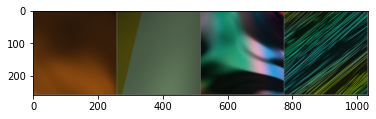

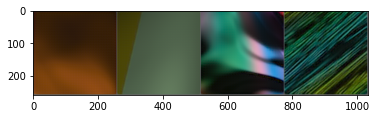

In [20]:
dataiter = iter(trainloader)
images = dataiter.next()[:4]
outputs = model(images.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(outputs))

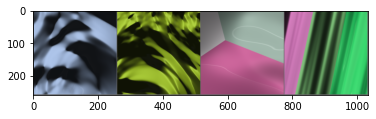

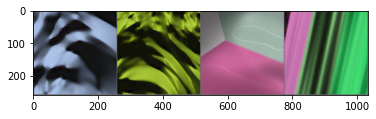

In [21]:
dataiter = iter(testloader)
images = dataiter.next()[:4]
outputs = model(images.to(device)).detach().cpu()
# show images
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(outputs))